Using device: cuda
Train: 7352 samples, Test: 2947 samples


Ablation 1_1: Modern TCN (Single Scale [k=3], No SE)
  - Parameters: 212,742
[Model 1-1 (K=3)] Epoch 25/50: Train Acc=99.27%, Test F1=0.9671, Test Acc=96.64% (Best F1: 0.9753, Best Acc: 97.49%)
[Model 1-1 (K=3)] Epoch 50/50: Train Acc=99.80%, Test F1=0.9690, Test Acc=96.84% (Best F1: 0.9753, Best Acc: 97.49%)

Ablation 1_2: Modern TCN (Single Scale [k=7], No SE)
  - Parameters: 216,838
[Model 1-2 (K=7)] Epoch 25/50: Train Acc=99.28%, Test F1=0.9664, Test Acc=96.64% (Best F1: 0.9727, Best Acc: 97.29%)
[Model 1-2 (K=7)] Epoch 50/50: Train Acc=99.93%, Test F1=0.9698, Test Acc=96.98% (Best F1: 0.9735, Best Acc: 97.35%)

Ablation 2: + Multi-scale (No SE)
  - Parameters: 351,494
[Model 2 (Multi)] Epoch 25/50: Train Acc=98.99%, Test F1=0.9683, Test Acc=96.78% (Best F1: 0.9711, Best Acc: 97.05%)
[Model 2 (Multi)] Epoch 50/50: Train Acc=99.88%, Test F1=0.9585, Test Acc=95.79% (Best F1: 0.9711, Best Acc: 97.05%)

Ablation 3: + Multi-sc

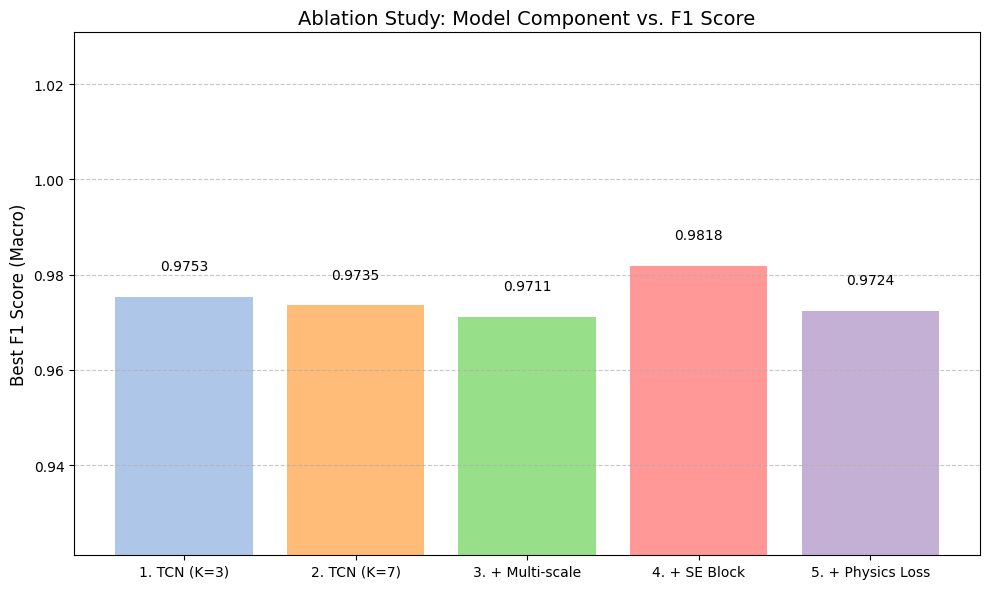

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import time
import random
from collections import deque
import matplotlib.pyplot as plt    
from sklearn.metrics import f1_score    

# ========================
# SEED 고정 함수
# ========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ========================
# UCI-HAR 데이터 로드 
# ========================
class UCIHARDataset(Dataset):
    def __init__(self, data_path, split='train'):
        base = Path(data_path) / split
        signals = []
        for sensor in ['body_acc', 'body_gyro', 'total_acc']:
            for axis in ['x', 'y', 'z']:
                file = base / 'Inertial Signals' / f'{sensor}_{axis}_{split}.txt'
                signals.append(np.loadtxt(file))

        self.X = np.stack(signals, axis=-1)
        self.y = np.loadtxt(base.parent / split / f'y_{split}.txt').astype(int) - 1

        try:
            self.subjects = np.loadtxt(base.parent / split / f'subject_{split}.txt').astype(int)
        except:
            self.subjects = np.ones(len(self.y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.X[idx]),
                torch.LongTensor([self.y[idx]])[0],
                self.subjects[idx])

# ========================
# 🔥 Modern TCN Components 
# ========================
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleConvBlock(nn.Module):
    def __init__(self, channels, kernel_sizes=[3, 5, 7], dilation=1, dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = ((k - 1) * dilation) // 2
            branch = nn.ModuleDict({
                'conv': DepthwiseSeparableConv1d(channels, channels, k, dilation, padding),
                'norm': nn.BatchNorm1d(channels),
                'dropout': nn.Dropout(dropout)
            })
            self.branches.append(branch)
        self.fusion = nn.Conv1d(channels * len(kernel_sizes), channels, 1)

    def forward(self, x):
        outputs = []
        target_length = x.size(2)
        for branch in self.branches:
            out = branch['conv'](x)
            if out.size(2) != target_length:
                out = out[:, :, :target_length]
            out = branch['norm'](out)
            out = F.gelu(out)
            out = branch['dropout'](out)
            outputs.append(out)
        multi_scale = torch.cat(outputs, dim=1)
        return self.fusion(multi_scale)

class ModernTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 7], dilation=1, dropout=0.1):
        super().__init__()
        
        # NOTE: kernel_sizes가 [7]처럼 단일 리스트로 들어오면 Single-scale이 됨
        self.multi_conv1 = MultiScaleConvBlock(
            in_channels if in_channels == out_channels else out_channels,
            kernel_sizes, dilation, dropout
        )
        
        # NOTE: kernel_sizes 중 가장 큰 값을 기준으로 padding
        max_k = max(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        padding = ((max_k - 1) * dilation) // 2
        
        self.conv2 = DepthwiseSeparableConv1d(
            out_channels, out_channels, max_k, dilation, padding
        )
        self.norm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        target_length = x.size(2)
        if self.downsample is not None:
            x = self.downsample(x)
            residual = x
        
        out = self.multi_conv1(x)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        
        out = self.conv2(out)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout2(out)
        return F.gelu(out + residual)

class SqueezeExcitation1d(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        batch, channels, _ = x.size()
        squeeze = F.adaptive_avg_pool1d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1)
        return x * excitation

class LargeKernelConv1d(nn.Module):
    def __init__(self, channels, kernel_size=21):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv1d(
            channels, channels, kernel_size,
            padding=padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.norm(out)
        return out

# ========================
# Modern TCN Base 모델 
# ========================
class BaseModernTCNHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
                 kernel_sizes=[3, 7], large_kernel=21, dropout=0.1, use_se=True):
        super().__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, 1)
        self.large_kernel_conv = LargeKernelConv1d(hidden_dim, large_kernel)
        self.tcn_blocks = nn.ModuleList()
        for i in range(n_layers):
            dilation = 2 ** i
            self.tcn_blocks.append(
                ModernTCNBlock(
                    hidden_dim, hidden_dim,
                    kernel_sizes=kernel_sizes,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.final_large_kernel = LargeKernelConv1d(hidden_dim, large_kernel)
        self.use_se = use_se
        if use_se:
            self.se = SqueezeExcitation1d(hidden_dim)
        self.norm_final = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.input_proj(x)
        x = self.large_kernel_conv(x)
        x = F.gelu(x)
        for block in self.tcn_blocks:
            x = block(x)
        x = self.final_large_kernel(x)
        x = F.gelu(x)
        if self.use_se:
            x = self.se(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.norm_final(x)
        return self.head(x)

# ========================
# Physics-Guided Modern TCN HAR 
# ========================
class PhysicsModernTCNHAR(BaseModernTCNHAR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        hidden_dim = self.head.in_features
        self.physics_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 6)
        )

    def forward(self, x, return_physics=False):
        x = x.transpose(1, 2)
        x_feat = self.input_proj(x)
        x_feat = self.large_kernel_conv(x_feat)
        x_feat = F.gelu(x_feat)
        for block in self.tcn_blocks:
            x_feat = block(x_feat)
        x_feat = self.final_large_kernel(x_feat)
        x_feat = F.gelu(x_feat)
        if self.use_se:
            x_feat = self.se(x_feat)
        
        # 1. 분류 헤드
        pooled = F.adaptive_avg_pool1d(x_feat, 1).squeeze(-1)
        pooled = self.norm_final(pooled)
        logits = self.head(pooled)

        if return_physics:
            # 2. 물리 헤드
            x_feat_transposed = x_feat.transpose(1, 2)
            physics = self.physics_head(x_feat_transposed)
            return logits, physics

        return logits

# ========================
# '물리 손실' 함수 
# ========================
def physics_loss(physics_pred, X_raw):
    acc_pred = physics_pred[:, :, :3]
    gyro_pred = physics_pred[:, :, 3:6]
    acc_true = X_raw[:, :, 0:3]
    gyro_true = X_raw[:, :, 3:6]
    return F.smooth_l1_loss(acc_pred, acc_true) + F.smooth_l1_loss(gyro_pred, gyro_true)

# ========================
# 헬퍼: 파라미터 카운트
# ========================
def get_n_params(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

# ========================
# '기본' 학습 함수 (F1 Score 기준)
# ========================
def train_base(model, train_loader, test_loader, device, epochs, model_name="Base"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    best_f1 = 0.0
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            
            # --- 기본 학습 (Physics Loss 없음) ---
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            # ------------------------------------

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        scheduler.step()

        model.eval()
        test_correct, test_total = 0, 0
        all_preds = [] 
        all_y = []  

        with torch.no_grad():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                
                # --- 기본 추론 ---
                logits = model(X)
                # -----------------
                
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item() 
                test_total += y.size(0)           

                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())

        train_acc = 100 * correct / total
        test_f1 = f1_score(all_y, all_preds, average='macro')
        test_acc = 100 * test_correct / test_total

        best_f1 = max(best_f1, test_f1) 
        best_acc = max(best_acc, test_acc)

        if (epoch + 1) % 25 == 0 or epoch == epochs - 1:
            print(f'[{model_name}] Epoch {epoch+1:02d}/{epochs}: Train Acc={train_acc:.2f}%, Test F1={test_f1:.4f}, Test Acc={test_acc:.2f}% (Best F1: {best_f1:.4f}, Best Acc: {best_acc:.2f}%)')

    return best_f1, best_acc 

# ========================
# '물리 기반' 학습 함수 (F1 Score 기준)
# ========================
def train_physics(model, train_loader, test_loader, device, epochs=50):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    best_f1 = 0.0
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits, physics = model(X, return_physics=True)

            loss_cls = F.cross_entropy(logits, y)
            loss_phys = physics_loss(physics, X)
            loss = loss_cls + 0.05 * loss_phys # Physics Loss 적용

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        scheduler.step()

        model.eval()
        test_correct, test_total = 0, 0
        all_preds = [] 
        all_y = []   

        with torch.no_grad():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X, return_physics=False)
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item() 
                test_total += y.size(0)         

                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())

        train_acc = 100 * correct / total
        test_f1 = f1_score(all_y, all_preds, average='macro')
        test_acc = 100 * test_correct / test_total

        best_f1 = max(best_f1, test_f1)
        best_acc = max(best_acc, test_acc)

        if (epoch + 1) % 25 == 0 or epoch == epochs - 1:
            print(f'[Physics] Epoch {epoch+1:02d}/{epochs}: Train Acc={train_acc:.2f}%, Test F1={test_f1:.4f}, Test Acc={test_acc:.2f}% (Best F1: {best_f1:.4f}, Best Acc: {best_acc:.2f}%)')
    
    return best_f1, best_acc

# ========================
# 시각화 함수
# ========================
def plot_results(results_dict):
    print("\n" + "="*90) # ⭐️ 너비 조절
    print("Ablation Study 최종 요약")
    print("="*90) # ⭐️ 너비 조절
    
    print(f"{'Model':<45} | {'Best Test F1':>20} | {'Best Test Acc (%)':>20}")
    print("-" * 89) # ⭐️ 45 + 23 + 23 = 91 (약간 조절)
    
    # 딕셔너리에서 F1과 Acc를 모두 꺼내서 출력
    for name, metrics in results_dict.items():
        print(f"{name:<45} | {metrics['f1']:>20.4f} | {metrics['acc']:>20.2f}")
    print("-" * 89)
    print("="*90)

    # --- 시각화 (F1 Score 기준) ---
    model_names = {
        '1-1. Modern TCN (Single Scale, No SE, 3)': '1. TCN (K=3)',
        '1-2. Modern TCN (Single Scale, No SE, 7)': '2. TCN (K=7)',
        '2. + Multi-scale': '3. + Multi-scale',
        '3. + Multi-scale + SE Block': '4. + SE Block',
        '4. + Physics Loss (Full)': '5. + Physics Loss'
    }
    
    names = [model_names.get(name, name) for name in results_dict.keys()]
    # F1 스코어만 추출하여 그래프 생성
    scores_f1 = [metrics['f1'] for metrics in results_dict.values()]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, scores_f1, color=['#AEC7E8', '#FFBB78', '#98DF8A', '#FF9896', '#C5B0D5'])
    plt.ylabel('Best F1 Score (Macro)', fontsize=12)
    plt.title('Ablation Study: Model Component vs. F1 Score', fontsize=14)
    plt.xticks(rotation=0, ha='center')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', 
                 ha='center', va='bottom', fontsize=10)

    min_score = min(scores_f1)
    plt.ylim(bottom=max(0, min_score - 0.05), top=max(scores_f1) * 1.05) 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 
    plt.show()

# ========================
# 메인 실행 함수 (Ablation Study)
# ========================
def main():
    set_seed(42) 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    data_path = 'C://Users/park9/ModernTCN_Pysics/data'

    try:
        train_ds = UCIHARDataset(data_path, split='train')
        test_ds = UCIHARDataset(data_path, split='test')
    except FileNotFoundError:
        print(f"Error: 데이터셋을 찾을 수 없습니다. 'data_path' 변수를 수정하세요.")
        print(f"현재 경로: {data_path}")
        return

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)
    print(f"Train: {len(train_ds)} samples, Test: {len(test_ds)} samples\n")
    
    EPOCHS = 50 # 공통 Epoch
    results = {} # 결과 저장 딕셔너리

    # ---
    # 🔬 1-1. Modern TCN (Single Scale [3])
    # ---
    print("\n" + "="*60)
    print("Ablation 1_1: Modern TCN (Single Scale [k=3], No SE)")
    print("="*60)
    set_seed(42) # ⭐️ Model 1 학습 직전에 SEED 리셋
    model1_1 = BaseModernTCNHAR(
        input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
        kernel_sizes=[3], use_se=False
    ).to(device)
    print(f"  - Parameters: {get_n_params(model1_1)}")
    f1_1_1, acc_1_1 = train_base(model1_1, train_loader, test_loader, device, epochs=EPOCHS, model_name="Model 1-1 (K=3)")
    results['1-1. Modern TCN (Single Scale, No SE, 3)'] = {'f1': f1_1_1, 'acc': acc_1_1}

    # ---
    # 🔬 1-2. Modern TCN (Single Scale [7])
    # ---
    print("\n" + "="*60)
    print("Ablation 1_2: Modern TCN (Single Scale [k=7], No SE)")
    print("="*60)
    set_seed(42) # ⭐️ SEED 리셋
    model1_2 = BaseModernTCNHAR(
        input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
        kernel_sizes=[7], use_se=False
    ).to(device)
    print(f"  - Parameters: {get_n_params(model1_2)}")
    f1_1_2, acc_1_2 = train_base(model1_2, train_loader, test_loader, device, epochs=EPOCHS, model_name="Model 1-2 (K=7)")
    results['1-2. Modern TCN (Single Scale, No SE, 7)'] = {'f1': f1_1_2, 'acc': acc_1_2}

    # ---
    # 🔬 2. + Multiple scale CNN
    # ---
    print("\n" + "="*60)
    print("Ablation 2: + Multi-scale (No SE)")
    print("="*60)
    set_seed(42) # ⭐️ SEED 리셋
    model2 = BaseModernTCNHAR(
        input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
        kernel_sizes=[3, 7], use_se=False
    ).to(device)
    print(f"  - Parameters: {get_n_params(model2)}")
    f1_2, acc_2 = train_base(model2, train_loader, test_loader, device, epochs=EPOCHS, model_name="Model 2 (Multi)")
    results['2. + Multi-scale'] = {'f1': f1_2, 'acc': acc_2}

    # ---
    # 🔬 3. + SE block
    # ---
    print("\n" + "="*60)
    print("Ablation 3: + Multi-scale + SE Block")
    print("="*60)
    set_seed(42) # ⭐️ SEED 리셋
    model3 = BaseModernTCNHAR(
        input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
        kernel_sizes=[3, 7], use_se=True
    ).to(device)
    print(f"  - Parameters: {get_n_params(model3)}")
    f1_3, acc_3 = train_base(model3, train_loader, test_loader, device, epochs=EPOCHS, model_name="Model 3 (Multi+SE)")
    results['3. + Multi-scale + SE Block'] = {'f1': f1_3, 'acc': acc_3}
    
    # ---
    # 🔬 4. + Physics Loss (Full Model)
    # ---
    print("\n" + "="*60)
    print("Ablation 4: + Multi-scale + SE Block + Physics Loss")
    print("="*60)
    set_seed(42) # ⭐️ SEED 리셋
    model4 = PhysicsModernTCNHAR(
        input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
        kernel_sizes=[3, 7], use_se=True
    ).to(device)
    print(f"  - Parameters: {get_n_params(model4)}")
    f1_4, acc_4 = train_physics(model4, train_loader, test_loader, device, epochs=EPOCHS)
    results['4. + Physics Loss (Full)'] = {'f1': f1_4, 'acc': acc_4}

    plot_results(results)


if __name__ == '__main__':
    main()